# Demo phần instance segmentation

Notebook này là một ví dụ về huấn luyện mô hình MaskRCNN, ứng dụng cho nhận dạng quần áo trong ảnh.

In [1]:
# Import các modules sẽ được dùng trong notebook
import pandas as pd
import numpy as np
import skimage.io as io
import json
import cv2

import matplotlib.pyplot as plt
from pycocotools.coco import COCO

import keras
import os

from maskrcnn_modanet.train.coco import CocoGenerator
from keras_retinanet.utils.transform import random_transform_generator
import keras.preprocessing.image
import tensorflow as tf

import keras_retinanet.losses
from keras_retinanet.callbacks import RedirectModel
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

from keras_maskrcnn import losses, models

Using TensorFlow backend.
/home/vankhoa/anaconda3/envs/py36tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vankhoa/anaconda3/envs/py36tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vankhoa/anaconda3/envs/py36tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vankhoa/ana

## 0. Phân tích dữ liệu

Định nghĩa đường dẫn tới nhãn, đã được chuyển hóa thành dạng coco:

In [2]:
ann_train_path = '/home/vankhoa/datasets/modanet/datasets/coco/annotations/instances_train.json'
ann_val_path = '/home/vankhoa/datasets/modanet/datasets/coco/annotations/instances_val.json'
ann_test_path = '/home/vankhoa/datasets/modanet/datasets/coco/annotations/instances_test.json'
path = '/home/vankhoa/datasets/modanet'
coco_path = '/home/vankhoa/datasets/modanet/datasets/coco/'
snapshot_path = '/home/vankhoa/dataset/modanet/results/snapshots/'

Mở dữ liệu trong các tệp nhãn, của các phần train, validaton và test:

In [3]:
with open(ann_train_path, 'r') as f:
    data = json.load(f)
print(data.keys())
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])
print(len(data['images']), len(data['annotations']), len(data['categories']))

# open one annotation coco
with open(ann_val_path, 'r') as f:
    data = json.load(f)
print(data.keys())
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])
print(len(data['images']), len(data['annotations']), len(data['categories']))

# open one annotation coco
with open(ann_test_path, 'r') as f:
    data = json.load(f)
print(data.keys())
print(data['images'][0])
print(data['annotations'][0])
print(data['categories'][0])
print(len(data['images']), len(data['annotations']), len(data['categories']))

dict_keys(['year', 'categories', 'annotations', 'licenses', 'type', 'info', 'images'])
{'file_name': '0736791.jpg', 'width': 400, 'id': 736791, 'license': 3, 'height': 600}
{'segmentation': [[161, 248, 170, 248, 173, 249, 189, 251, 199, 252, 199, 250, 212, 250, 212, 252, 224, 253, 239, 251, 248, 250, 257, 247, 257, 253, 249, 255, 248, 260, 248, 265, 228, 264, 215, 264, 200, 264, 196, 261, 189, 260, 182, 259, 171, 259, 164, 255, 160, 254, 161, 254]], 'area': 1746, 'iscrowd': 0, 'image_id': 736791, 'bbox': [160, 247, 97, 18], 'category_id': 2, 'id': 0}
{'supercategory': 'fashion', 'id': 1, 'name': 'bag'}
41877 219777 13
dict_keys(['year', 'categories', 'annotations', 'licenses', 'type', 'info', 'images'])
{'file_name': '1019820.jpg', 'width': 400, 'id': 1019820, 'license': 3, 'height': 600}
{'segmentation': [[264, 274, 277, 270, 289, 262, 296, 255, 302, 245, 298, 233, 288, 218, 280, 202, 269, 189, 267, 193, 268, 207, 269, 236, 265, 257, 263, 269], [236, 168, 234, 153, 234, 137, 238, 127,

Sử dụng thư viện pycocotools để quản lý nhãn dưới dạng coco, hiển thị các dạng quần áo (category) có trong tệp nhãn:

In [4]:
# Initialize the COCO api for instance annotations
coco=COCO(ann_train_path)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(f'Các dạng quần áo có trong dữ liệu: {cats}')

loading annotations into memory...
Done (t=1.89s)
creating index...
index created!
Các dạng quần áo có trong dữ liệu: [{'supercategory': 'fashion', 'id': 1, 'name': 'bag'}, {'supercategory': 'fashion', 'id': 2, 'name': 'belt'}, {'supercategory': 'fashion', 'id': 3, 'name': 'boots'}, {'supercategory': 'fashion', 'id': 4, 'name': 'footwear'}, {'supercategory': 'fashion', 'id': 5, 'name': 'outer'}, {'supercategory': 'fashion', 'id': 6, 'name': 'dress'}, {'supercategory': 'fashion', 'id': 7, 'name': 'sunglasses'}, {'supercategory': 'fashion', 'id': 8, 'name': 'pants'}, {'supercategory': 'fashion', 'id': 9, 'name': 'top'}, {'supercategory': 'fashion', 'id': 10, 'name': 'shorts'}, {'supercategory': 'fashion', 'id': 11, 'name': 'skirt'}, {'supercategory': 'fashion', 'id': 12, 'name': 'headwear'}, {'supercategory': 'fashion', 'id': 13, 'name': 'scarf/tie'}]


Vẽ ra một mẫu (sample) trong tập dữ liệu:

[6]
Number of images containing all the  classes: 41877
0720233.jpg


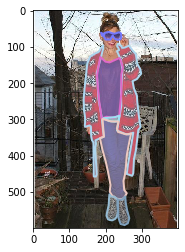

In [5]:
# Fetch class IDs only corresponding to the filterClasses
catIds = coco.getCatIds(catNms='dress') 
print(catIds)

# Get all images containing the above Category IDs
imgIds = coco.getImgIds()
print("Number of images containing all the  classes:", len(imgIds))

idx = np.random.randint(0,len(imgIds))


# load and display a random image
img = coco.loadImgs(imgIds[idx])[0]
print(img['file_name'])
I = io.imread('{}/images/{}'.format(coco_path,img['file_name']))/255.0

plt.imshow(I)
annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

## 1. Khởi tạo Dataloader

In [6]:
transform_generator = random_transform_generator(flip_x_chance=0.5)

train_generator = CocoGenerator(
    coco_path,
    'train',
    transform_generator=transform_generator,
    batch_size=4,
    config=None,
    image_min_side=800,
    image_max_side=1333
)

validation_generator = CocoGenerator(
    coco_path,
    'val',
    batch_size=1,
    config=None,
    image_min_side=800,
    image_max_side=1333
)

loading annotations into memory...
Done (t=1.83s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


## 2. Khởi tạo mô hình, định nghĩa hàm loss và optimizer

In [7]:
# Model
    
backbone = models.backbone('resnet50')

model  = backbone.maskrcnn(
            num_classes=train_generator.num_classes(),
            nms=True,
            class_specific_filter=True,
            modifier=None,
            anchor_params=None
        )


# compile model
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal(),
        'masks'         : losses.mask(),
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
)

print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.


/home/vankhoa/anaconda3/envs/py36tf/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Output "filtered_detections" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "filtered_detections" during training.
/home/vankhoa/anaconda3/envs/py36tf/lib/python3.6/site-packages/ipykernel_launcher.py:21: UserWarning: Output "mask_submodel" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mask_submodel" during training.


Model: "retinanet-mask"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        image[0][0]                      
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (Activation)         (None, None, None, 6 0           bn_conv1[0][0]                   
_____________________________________________________________________________________

Định nghĩa hàm callback cho keras:

In [8]:
callbacks = []

# save the prediction model
# ensure directory created first; otherwise h5py will error after epoch.
os.makedirs(snapshot_path, exist_ok=True)
checkpoint = keras.callbacks.ModelCheckpoint(
    os.path.join(
        snapshot_path,
        '{backbone}_{dataset_type}_{{epoch:02d}}.h5'.format(backbone='resnet50', dataset_type='coco')
    ),
    verbose=1
)
checkpoint = RedirectModel(checkpoint, model)
callbacks.append(checkpoint)

tensorboard_callback = None


from keras_maskrcnn.callbacks.coco import CocoEval

# use prediction model for evaluation
evaluation = CocoEval(validation_generator)
evaluation = RedirectModel(evaluation, model)
callbacks.append(evaluation)

Huấn luyện mô hình dựa trên dữ liệu:

In [10]:
model.fit_generator(
        generator=train_generator,
        steps_per_epoch=100,
        epochs=3,
        verbose=1,
        callbacks=callbacks,
        workers=8,
        use_multiprocessing=True,
        max_queue_size=10
    )

Instructions for updating:
Use tf.cast instead.
Epoch 1/3
  9/100 [=>............................] - ETA: 43:40 - loss: 70939.0009 - regression_loss: 166.1348 - classification_loss: 70772.8668 - masks_loss: 0.0000e+00

Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-7:
Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):


## 3. Đánh giá mô hình sau khi huấn luyện

In [46]:
from keras_maskrcnn.utils.coco_eval import evaluate_coco

evaluate_coco(validation_generator, model)

Loading and preparing results...
DONE (t=2.88s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=23.03s).
Accumulating evaluation results...
DONE (t=5.73s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.795
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.554
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.619
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.623
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1

## 4. Dùng mô hình để dự đoán ảnh

Load lại các ma trận trọng số đã được huấn luyện vào mô hình:

In [9]:
# Load segmentation model
labels_to_names = {0: 'bag', 1: 'belt', 2: 'boots', 3: 'footwear', 4: 'outer', 5: 'dress', 6: 'sunglasses', 7: 'pants', 8: 'top', 9: 'shorts', 10: 'skirt', 11: 'headwear', 12: 'scarf/tie'}

model_path = path + '/results/resnet50_modanet.h5'
model = models.load_model(model_path, backbone_name='resnet50')

/home/vankhoa/anaconda3/envs/py36tf/lib/python3.6/site-packages/keras/engine/saving.py:335: UserWarning: Output "filtered_detections" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "filtered_detections" during training.
  sample_weight_mode=sample_weight_mode)
/home/vankhoa/anaconda3/envs/py36tf/lib/python3.6/site-packages/keras/engine/saving.py:335: UserWarning: Output "mask_submodel" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mask_submodel" during training.
  sample_weight_mode=sample_weight_mode)
/home/vankhoa/anaconda3/envs/py36tf/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use tf.cast instead.


Hàm dự đoán:

In [10]:
def predict(img_path):
    image = read_image_bgr(img_path)

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    outputs = model.predict_on_batch(np.expand_dims(image, axis=0))

    boxes  = outputs[-4][0]
    scores = outputs[-3][0]
    labels = outputs[-2][0]
    masks  = outputs[-1][0]

    # correct for image scale
    boxes /= scale

    for box, score, label, mask in zip(boxes, scores, labels, masks):
        if score < 0.5:
            break
        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        mask = mask[:, :, label]
        draw_mask(draw, b, mask, color=label_color(label))

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)
    return draw

Hàm hiển thị kết quả dự đoán của mô hình:

In [31]:
def plot_pred(img_path, img_id, draw):
    image = read_image_bgr(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure().clear()
    f = plt.figure(figsize=(20, 20))
    ax = f.add_subplot(1,3, 1)
    plt.imshow(image)
    ax.set_xlabel('Original image')

    ax = f.add_subplot(1,3,2)
    
    plt.imshow(image)
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
    ax.set_xlabel('Image with annotations')

    ax = f.add_subplot(1,3,3)
    plt.imshow(draw)
    ax.set_xlabel('Image with predictions')

    plt.show()

Vẽ 10 kết quả:

<Figure size 432x288 with 0 Axes>

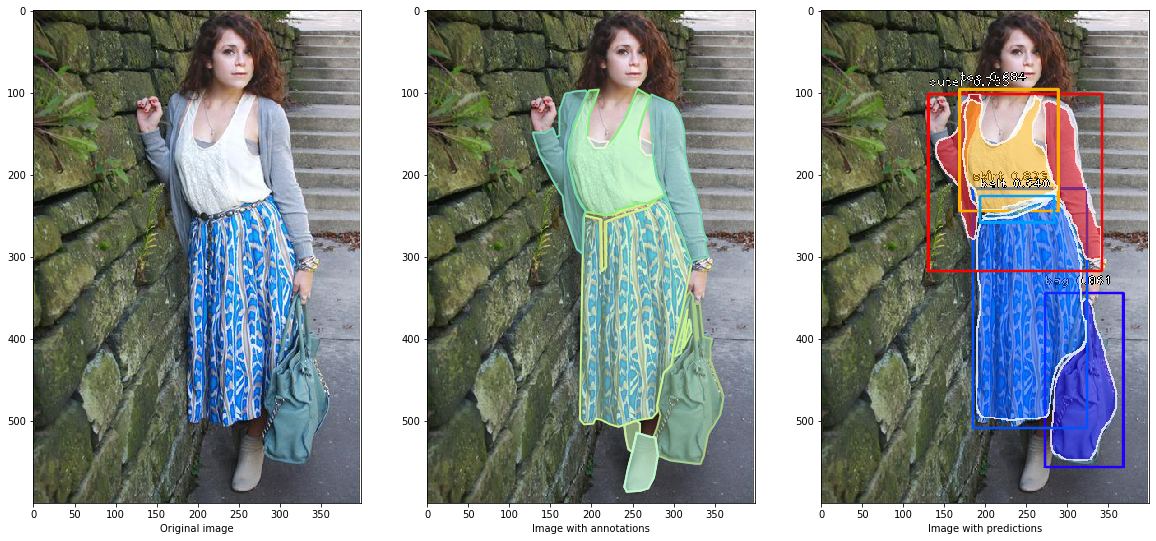

<Figure size 432x288 with 0 Axes>

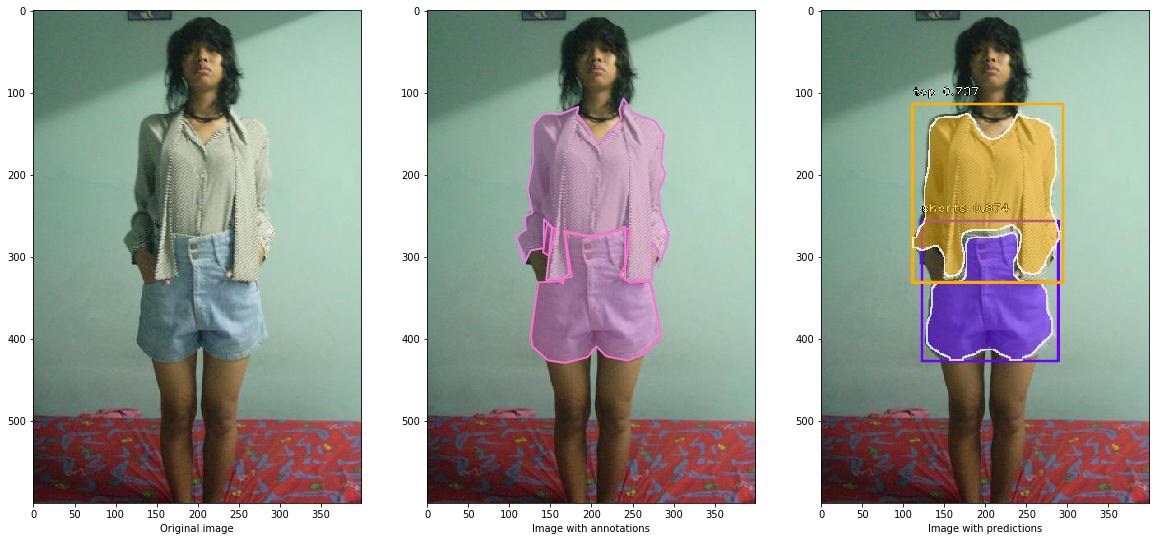

<Figure size 432x288 with 0 Axes>

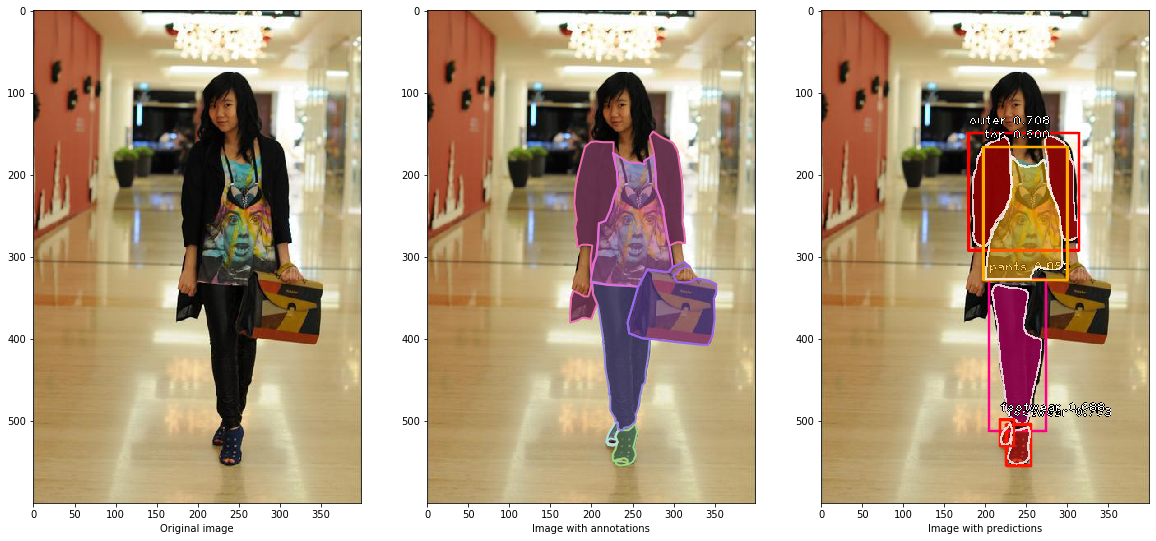

<Figure size 432x288 with 0 Axes>

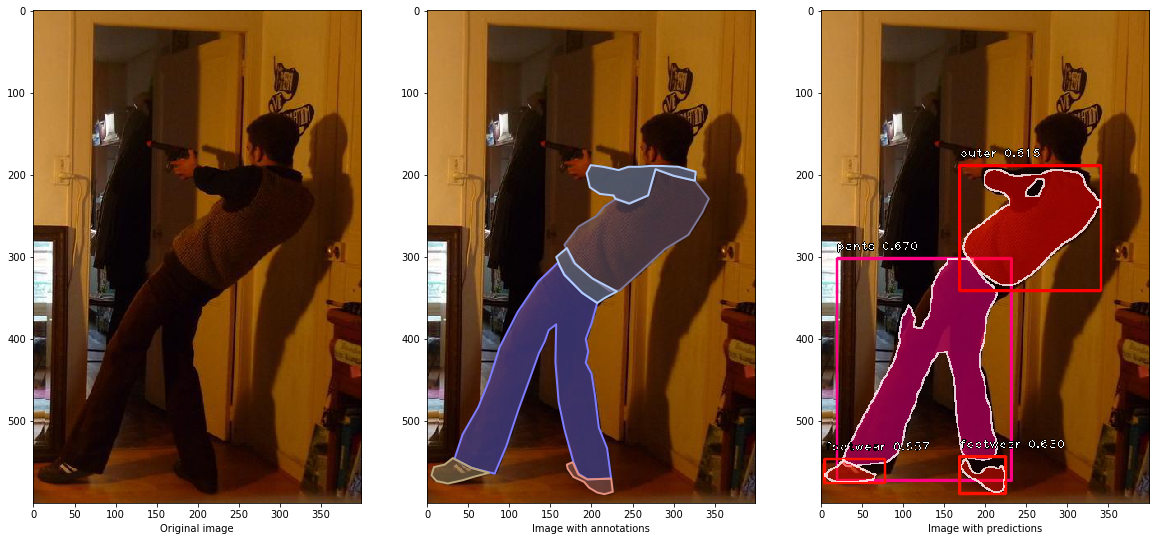

<Figure size 432x288 with 0 Axes>

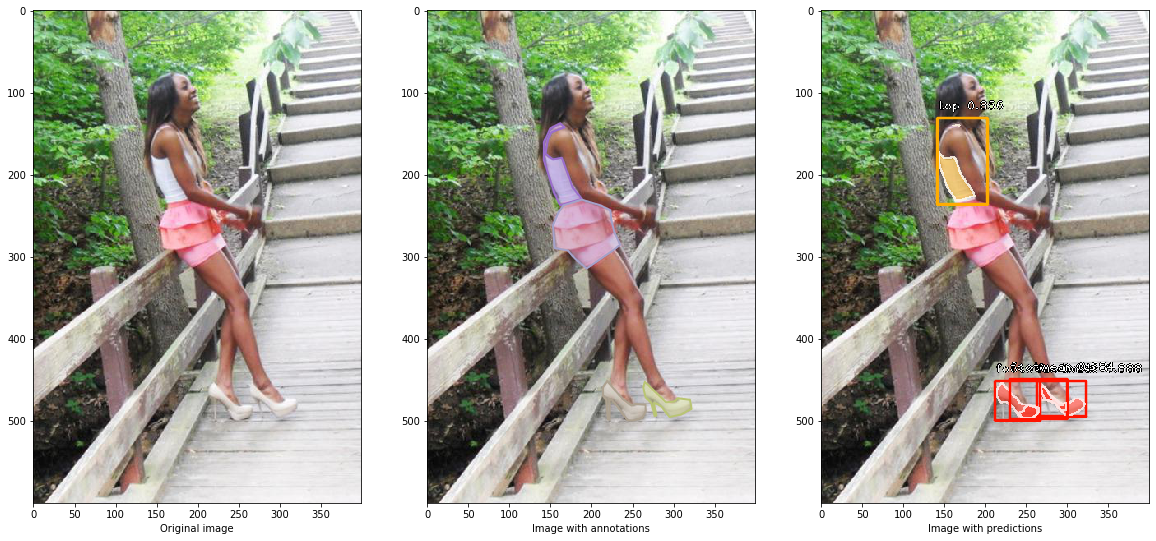

<Figure size 432x288 with 0 Axes>

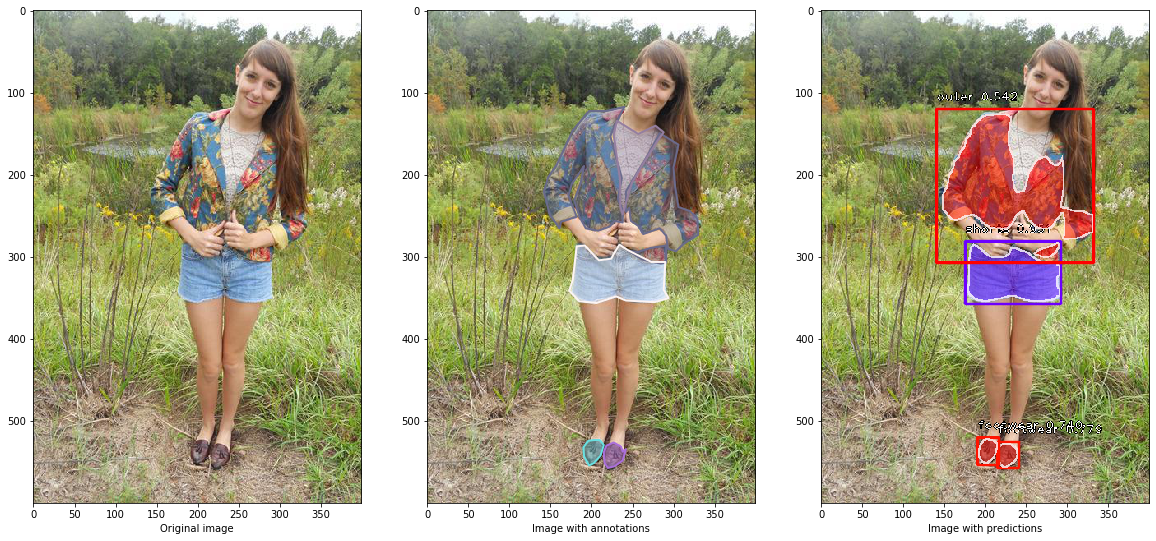

<Figure size 432x288 with 0 Axes>

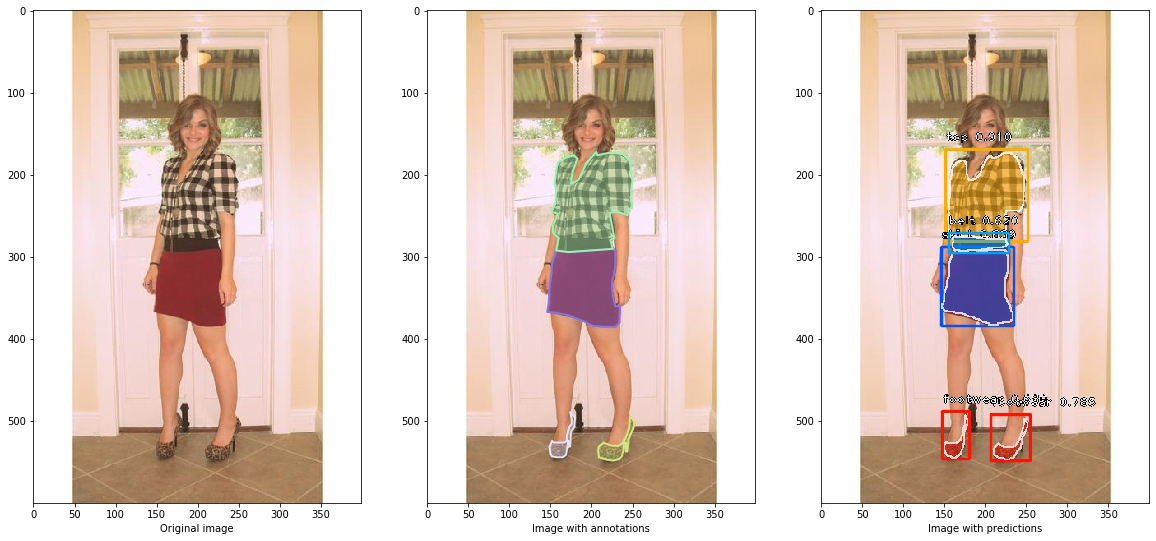

<Figure size 432x288 with 0 Axes>

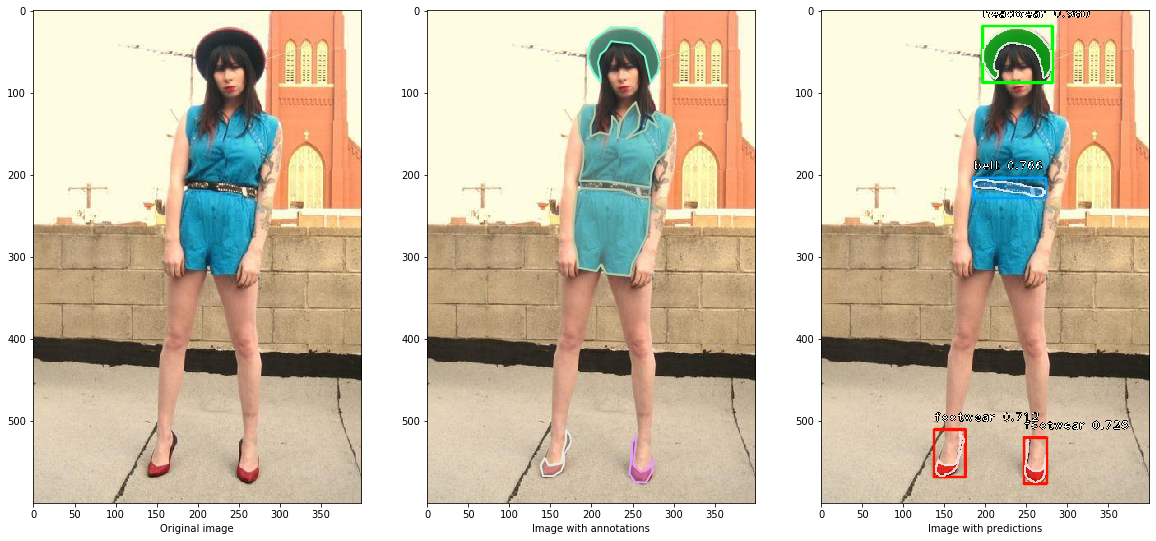

<Figure size 432x288 with 0 Axes>

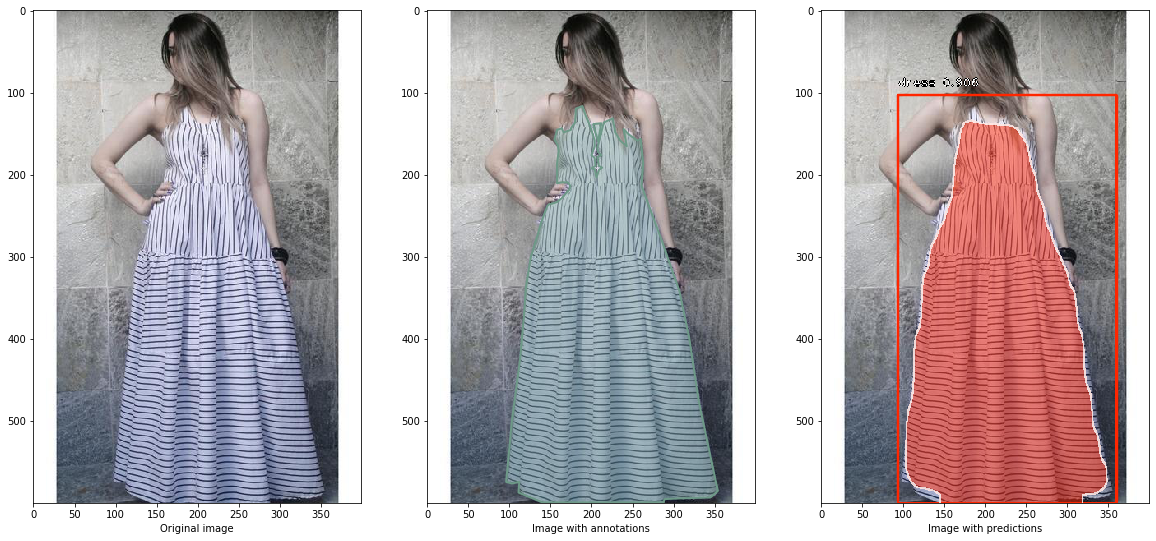

<Figure size 432x288 with 0 Axes>

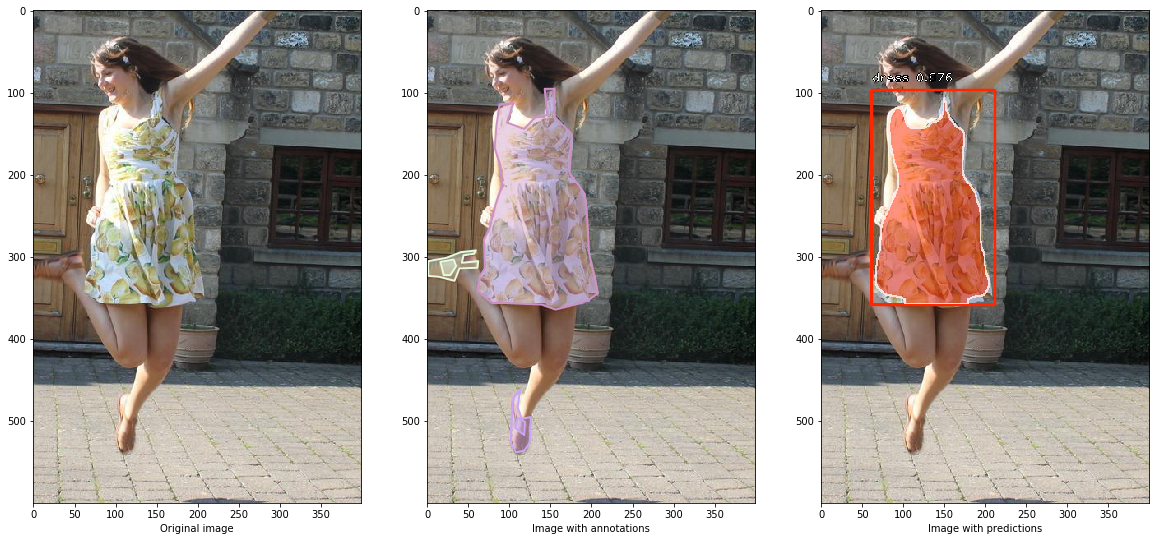

In [33]:
for i in range(10):
    idx = np.random.randint(0,len(imgIds))

    # load and display a random image
    img = coco.loadImgs(imgIds[idx])[0]
    img_path = coco_path + '/images/' + img['file_name']
    draw = predict(img_path)
    plot_pred(img_path=img_path, img_id=img['id'], draw=draw)